In [40]:
from langgraph.graph import MessagesState, StateGraph, START, END
import operator, json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [41]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Gemma2-9b-It")

In [42]:
llm.invoke("hi").content

'Hi! 👋\n\nWhat can I do for you today? 😊\n'

In [43]:
@tool
def multiply(first_number: int, second_number: int):
    """multiply two integer number"""
    return first_number * second_number

In [44]:
multiply({"first_number": 12, "second_number": 5})

60

In [45]:
multiply.invoke({"first_number": 12, "second_number": 5})

60

In [46]:
@tool
def search(query: str):
    """perform the web search on the user query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

In [47]:
search("Who is a current president of USA?")

[{'url': 'https://simple.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is also the head of the executive branch of the federal government of the United States and is the chairman of the presidential cabinet.[10]\nJoe Biden is the 46th and current president of the United States, in office since January 2021.[11]\nEligibility and requirements[change | change source]\nArticle II, Section 1, Clause 5 of the constitution states for a person to serve as president must:\nElection process and presidential terms[change | change source]\nThe president is elected by the people through the Electoral College to a four-year term, along with the vice presidential candidate or the incumbent vice president of the United States as their running mate.[12] Contents\nPresident of the United States\nThe president of the United States (POTUS)[9] is the head of state and head of government of the United States of America and the commander-in-chief of the United States Armed F

In [48]:
tools = [search, multiply]

In [49]:
llm_with_tools = llm.bind_tools(tools)

In [50]:
tool_mapping = {tool.name: tool for tool in tools}

In [51]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000021ED40D5C60>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000021ED40D5510>)}

In [52]:
response = llm_with_tools.invoke("who is a current president of USA?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_90q3', 'function': {'arguments': '{"query":"current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1076, 'total_tokens': 1159, 'completion_time': 0.150909091, 'prompt_time': 0.035922866, 'queue_time': 0.019864163000000004, 'total_time': 0.186831957}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2e1690c8-4125-4787-b836-a013d688e348-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': 'call_90q3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 83, 'total_tokens': 1159})

In [53]:
tool_details = response.additional_kwargs.get("tool_calls")
tool_details

[{'id': 'call_90q3',
  'function': {'arguments': '{"query":"current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [54]:
tool_details[0]['function']['name']

'search'

In [55]:
tool_details[0]['function']['arguments']

'{"query":"current president of USA"}'

In [56]:
json.loads(tool_details[0]['function']['arguments'])

{'query': 'current president of USA'}

In [57]:
tool_mapping[tool_details[0]['function']['name']].invoke(tool_details[0]['function']['arguments'])

[{'url': 'https://simple.wikipedia.org/wiki/President_of_the_United_States',
  'content': 'The president is also the head of the executive branch of the federal government of the United States and is the chairman of the presidential cabinet.[10]\nJoe Biden is the 46th and current president of the United States, in office since January 2021.[11]\nEligibility and requirements[change | change source]\nArticle II, Section 1, Clause 5 of the constitution states for a person to serve as president must:\nElection process and presidential terms[change | change source]\nThe president is elected by the people through the Electoral College to a four-year term, along with the vice presidential candidate or the incumbent vice president of the United States as their running mate.[12] Contents\nPresident of the United States\nThe president of the United States (POTUS)[9] is the head of state and head of government of the United States of America and the commander-in-chief of the United States Armed F

In [58]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [59]:
def invoke_model(state: AgentState):
    messages = state['messages']
    question = messages[-1]
    return {"messages": [llm_with_tools.invoke(question)]}

In [60]:
def invoke_tool(state: AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages": [response]}

In [61]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [62]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tool": "tool",
        "end": END
    }
)

# graph.add_edge("tool", "ai_assistant")

graph.add_edge("tool", END)

graph.set_entry_point("ai_assistant")


In [63]:
app = graph.compile()

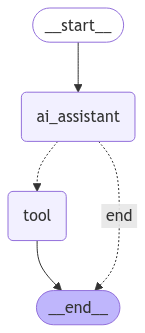

In [64]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [65]:
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("--------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_efdq', 'function': {'arguments': '{"query":"who is the upcoming president of the USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1075, 'total_tokens': 1162, 'completion_time': 0.158181818, 'prompt_time': 0.043354077, 'queue_time': 0.019926306999999997, 'total_time': 0.201535895}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f2ecd2cd-0b58-4218-a791-08235e381062-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the upcoming president of the USA'}, 'id': 'call_efdq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 87, 'total_tokens': 1162})]}
--------
Selected tool: search
{'messages': [[{'url': 'https://www.business-standard.com/world-news/how-the-us-will-choose-its-next-president-election-process-explained-

In [66]:
for s in app.stream({"messages": ["what is multiplication of 23 and 33"]}):
    print(list(s.values())[0])
    print("--------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w1yy', 'function': {'arguments': '{"first_number":23,"second_number":33}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1079, 'total_tokens': 1172, 'completion_time': 0.169090909, 'prompt_time': 0.043786726, 'queue_time': 0.022510744, 'total_time': 0.212877635}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f911573-7ce4-4176-b466-0981e195ccb8-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 33}, 'id': 'call_w1yy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1079, 'output_tokens': 93, 'total_tokens': 1172})]}
--------
Selected tool: multiply
{'messages': [759]}
--------


In [67]:
for s in app.stream({"messages": ["what is the total amount of money in the entire earth"]}):
    print(list(s.values())[0])
    print("--------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_46gf', 'function': {'arguments': '{"query":"total amount of money in the world"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1079, 'total_tokens': 1165, 'completion_time': 0.156363636, 'prompt_time': 0.057998329, 'queue_time': 0.024118692999999997, 'total_time': 0.214361965}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-53c2d9d7-f041-444a-9311-a9b6c11c818f-0', tool_calls=[{'name': 'search', 'args': {'query': 'total amount of money in the world'}, 'id': 'call_46gf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1079, 'output_tokens': 86, 'total_tokens': 1165})]}
--------
Selected tool: search
{'messages': [[{'url': 'https://www.ncesc.com/geographic-faq/how-much-money-has-exists-in-the-world/', 'content': 'How much money has exists in the wo

In [68]:
for s in app.stream({"messages": ["what is the total amount of money in the entire earth"]}):
    print(list(s.values())[0])
    print("--------")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wwvx', 'function': {'arguments': '{"query":"total amount of money in the world"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1079, 'total_tokens': 1165, 'completion_time': 0.156363636, 'prompt_time': 0.034491111, 'queue_time': 0.022170418000000004, 'total_time': 0.190854747}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6184e155-8294-4147-9465-3b804389cb60-0', tool_calls=[{'name': 'search', 'args': {'query': 'total amount of money in the world'}, 'id': 'call_wwvx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1079, 'output_tokens': 86, 'total_tokens': 1165})]}
--------
Selected tool: search


Exception: web search discard

### LangGraph suports human-in-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node

In [69]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Gemma2-9b-It")

In [70]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [71]:
tavily = TavilySearchResults()

In [72]:
tools = [tavily]

In [73]:
llm_with_tools = llm.bind_tools(tools)

In [74]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [75]:
memory = MemorySaver()

In [77]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition
)
graph_builder.add_edge("tools", "ai_assistant")

app2 = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

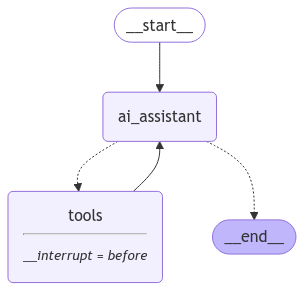

In [78]:
from IPython.display import Image, display

try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [192]:
user_input = "what is the capital of india?"
config = {"configurable": {"thread_id": "8"}}

In [193]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [194]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

what is the capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zmvd)
 Call ID: call_zmvd
  Args:
    query: What is the capital of India?


In [195]:
snapshot = app2.get_state(config)

In [196]:
snapshot.next

('tools',)

In [197]:
last_message = snapshot.values["messages"][-1]

In [198]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'What is the capital of India?'},
  'id': 'call_zmvd',
  'type': 'tool_call'}]

In [199]:
# None will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [200]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zmvd)
 Call ID: call_zmvd
  Args:
    query: What is the capital of India?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.geeksforgeeks.org/what-is-the-capital-city-of-india/", "content": "The capital city of India is New Delhi, situated in the northern part of the country. It was officially declared the capital of India in 1911 during British rule, replacing Kolkata. New Delhi serves as the political, cultural, and administrative center of India. The city is renowned for its rich history, diverse culture, and architectural"}, {"url": "https://www.worldatlas.com/articles/what-is-the-capital-of-india.html", "content": "Related\nThe Largest Empires In The History Of India\nBiggest Ethnic Groups In India\nMore in World Facts\nThe Largest Countries In Asia By Area\n Also, the

In [161]:
user_input = "What is a weather in Delhi?"

config = {"configurable": {"thread_id": "6"}}

In [162]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [163]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

What is a weather in Delhi?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rnk0)
 Call ID: call_rnk0
  Args:
    query: weather in Delhi


In [164]:
snapshot = app2.get_state(config)

In [165]:
snapshot.next

('tools',)

In [166]:
last_message = snapshot.values["messages"][-1]

In [167]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Delhi'},
  'id': 'call_rnk0',
  'type': 'tool_call'}]

In [170]:
# None will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [171]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================

```json
{"tool_call":{"id":"call_rnk0","type":"function","function":{"name":"tavily_search_results_json"},"parameters":{"query":"weather in Delhi"}}}
```


In [172]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "6"}}

In [173]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [174]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_aefv)
 Call ID: call_aefv
  Args:
    query: recent news Delhi weather


In [175]:
snapshot=app2.get_state(config)

In [176]:
current_message = snapshot.values["messages"][-1]

In [177]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_aefv)
 Call ID: call_aefv
  Args:
    query: recent news Delhi weather


In [178]:
tool_call_id = current_message.tool_calls[0]["id"] 

In [179]:
tool_call_id

'call_aefv'

In [180]:
from langchain_core.messages import AIMessage, ToolMessage

In [181]:
answer = "it is just related to raining which is happing on daily basis"

In [182]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [183]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcd217-4893-6dfa-8007-ee1e9bea2ecb'}}

In [184]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='fb66b7ab-5629-41be-8826-c647f37ebd0a')]
